In [12]:
# !pip install torch
# !pip install torchvision

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [15]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [16]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [17]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.73MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1, Loss: 164.8485989420573
Epoch 2, Loss: 121.42219446614584
Epoch 3, Loss: 114.47182703450521
Epoch 4, Loss: 111.65288460286459
Epoch 5, Loss: 109.90579399414062
Epoch 6, Loss: 108.74398286132812
Epoch 7, Loss: 107.92627141927083
Epoch 8, Loss: 107.26012202148438
Epoch 9, Loss: 106.74345738932291
Epoch 10, Loss: 106.36903325195313


In [18]:
import matplotlib.pyplot as plt


def generate_images(model, num_images=10, latent_dim=20):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim)
        generated_images = model.decode(z).cpu()

    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')
        axs[i].axis('off')
    plt.show()




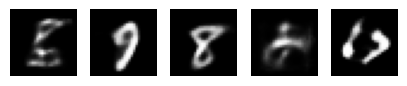

In [19]:
generate_images(vae, num_images=5, latent_dim=20)

Task 1: Modify the VAE architecture to use convolutional layers for both the encoder and decoder, and train it on the CIFAR-10 dataset. This modification will allow the model to capture spatial relationships within images more effectively, improving its ability to generate high-quality images. After training, compare the generated images with those from a fully connected VAE.

Files already downloaded and verified
Epoch 1, Loss: 117.75153705078125
Epoch 2, Loss: 84.09979545898437
Epoch 3, Loss: 79.74381274414063
Epoch 4, Loss: 78.43982765625
Epoch 5, Loss: 77.69290485351563
Epoch 6, Loss: 77.05875447265625
Epoch 7, Loss: 76.54311198242188
Epoch 8, Loss: 76.22927495117187
Epoch 9, Loss: 75.82949255859376
Epoch 10, Loss: 75.61358473632812


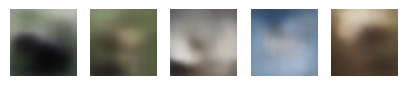

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)


        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = ConvVAE(latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def train(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')

train(vae, train_loader, optimizer, num_epochs=10)


def generate_images(model, num_images=5, latent_dim=128):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decode(z).cpu()
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 2))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()


generate_images(vae, num_images=5, latent_dim=128)

Task 2: Using the trained VAE, interpolate between two images in the latent space and generate intermediate images. This demonstrates how smoothly the model can transition between different data points. Visualize
and display the results, showing the interpolated images in a grid format to observe the transformation.

Files already downloaded and verified


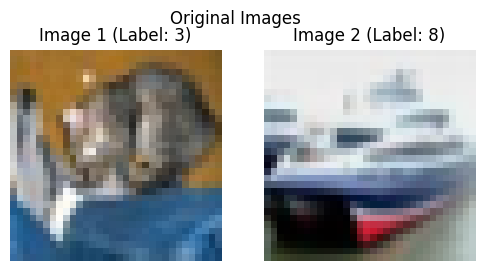

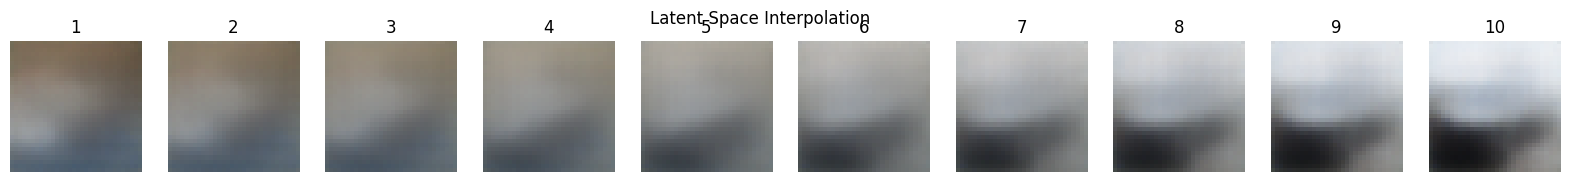

In [21]:
def interpolate_images(model, img1, img2, num_steps=10):
    model.eval()
    with torch.no_grad():
        mu1, _ = model.encode(img1.unsqueeze(0).to(device))
        mu2, _ = model.encode(img2.unsqueeze(0).to(device))

        interpolated_images = []

        interpolation_factors = torch.linspace(0, 1, steps=num_steps)

        for alpha in interpolation_factors:
            z = (1 - alpha) * mu1 + alpha * mu2
            recon = model.decode(z)
            interpolated_images.append(recon.squeeze(0).cpu())

    return interpolated_images



test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

img1, label1 = test_dataset[0]
img2, label2 = test_dataset[1]


fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img1.permute(1, 2, 0))
axs[0].set_title(f'Image 1 (Label: {label1})')
axs[0].axis('off')
axs[1].imshow(img2.permute(1, 2, 0))
axs[1].set_title(f'Image 2 (Label: {label2})')
axs[1].axis('off')
plt.suptitle("Original Images")
plt.show()


num_steps = 10
interpolated_images = interpolate_images(vae, img1, img2, num_steps=num_steps)


fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))
for idx, img in enumerate(interpolated_images):
    axes[idx].imshow(img.permute(1, 2, 0))
    axes[idx].set_title(f'{idx+1}')
    axes[idx].axis('off')
plt.suptitle("Latent Space Interpolation")
plt.show()

Task 3: Train the VAE on a new dataset of your choice (e.g., CelebA for faces), and visualize generated samples. Experiment with sampling from different regions of the latent space and analyze how the generated outputs vary based on different latent vectors.



Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
50k-celeba-dataset-64x64.zip: Skipping, found more recently modified local copy (use --force to force download)
replace celeba_64/50k/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Found 50000 images in ./celeba_64
Epoch [1/10], Loss: 401.2150
Epoch [2/10], Loss: 236.3383
Epoch [3/10], Loss: 212.6846
Epoch [4/10], Loss: 203.5287
Epoch [5/10], Loss: 198.2734
Epoch [6/10], Loss: 194.7579
Epoch [7/10], Loss: 192.3561
Epoch [8/10], Loss: 190.3011
Epoch [9/10], Loss: 188.5780
Epoch [10/10], Loss: 187.1841


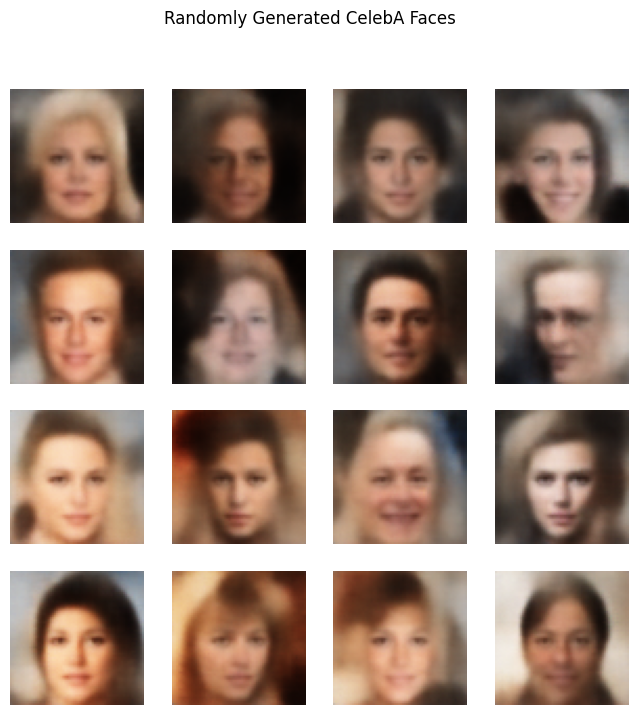

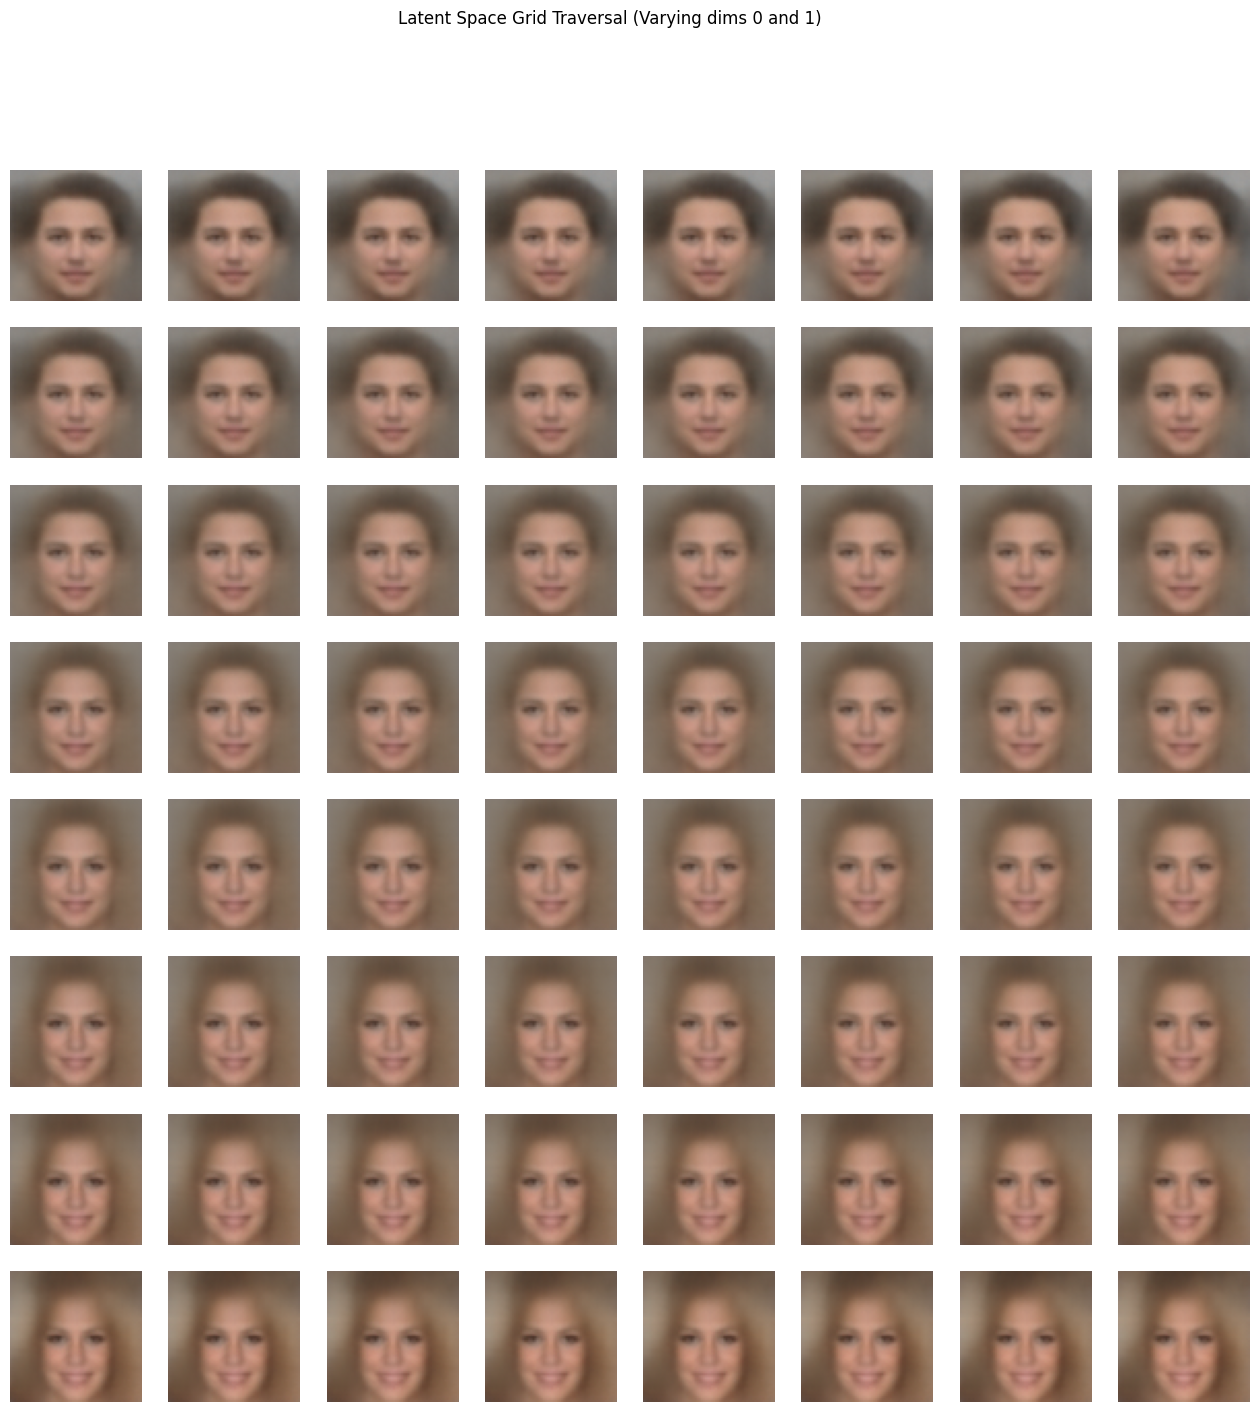

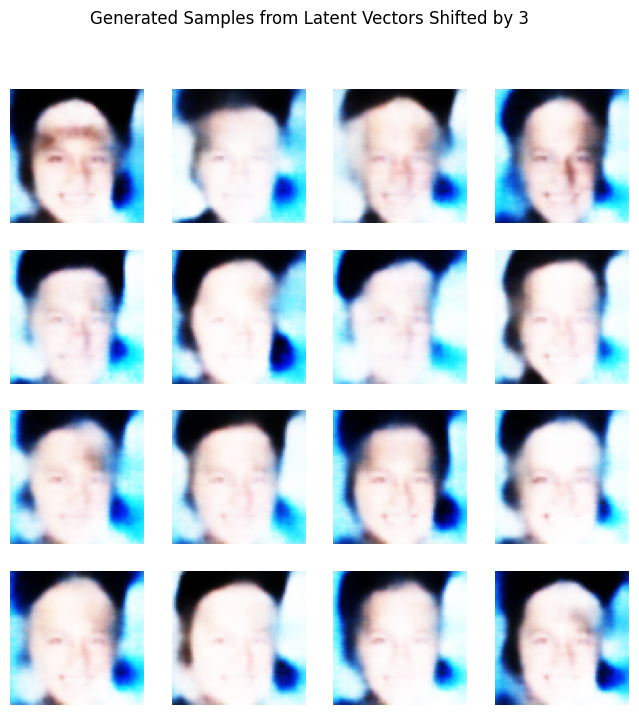

In [22]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64
!unzip -q 50k-celeba-dataset-64x64.zip -d celeba_64


import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class CelebADataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = []
        for subdir, _, files in os.walk(self.root):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_files.append(os.path.join(subdir, file))
        print(f"Found {len(self.image_files)} images in {self.root}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = CelebADataset(root='./celeba_64', transform=transform)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.ReLU(),
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar


def loss_function(recon_x, x, mu, logvar):
    mse = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kld


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = ConvVAE(latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def train(model, dataloader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


train(vae, train_loader, optimizer, num_epochs=10)


def generate_samples(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 128).to(device)
        samples = model.decode(z).cpu()
    grid_size = int(num_samples**0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            axes[i, j].imshow(samples[idx].permute(1, 2, 0))
            axes[i, j].axis('off')
    plt.suptitle("Randomly Generated CelebA Faces")
    plt.show()


generate_samples(vae, num_samples=16)


def visualize_latent_grid(model, grid_size=8):
    model.eval()
    with torch.no_grad():
        z = torch.zeros(grid_size * grid_size, 128).to(device)
        x_values = torch.linspace(-3, 3, grid_size)
        y_values = torch.linspace(-3, 3, grid_size)
        for i, x_val in enumerate(x_values):
            for j, y_val in enumerate(y_values):
                index = i * grid_size + j
                z[index, 0] = x_val
                z[index, 1] = y_val
        generated = model.decode(z).cpu()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            axes[i, j].imshow(generated[idx].permute(1, 2, 0))
            axes[i, j].axis('off')
    plt.suptitle("Latent Space Grid Traversal (Varying dims 0 and 1)")
    plt.show()


visualize_latent_grid(vae, grid_size=8)


def sample_shifted_latents(model, offset=3, num_samples=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 128).to(device) + offset
        generated = model.decode(z).cpu()
    grid_size = int(num_samples**0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            axes[i, j].imshow(generated[idx].permute(1, 2, 0))
            axes[i, j].axis('off')
    plt.suptitle(f"Generated Samples from Latent Vectors Shifted by {offset}")
    plt.show()

sample_shifted_latents(vae, offset=3, num_samples=16)